In [42]:
import numpy as np
import bisect

from matplotlib import pyplot as plt
import matplotlib

In [2]:
from pixel3d import Pixel3D

In [3]:
from topologicalunionfind import TopologicalUnionFind

### Reading Slice

In [4]:
binary = np.fromfile('../cube/map.bin')
binary.shape

(87464,)

In [5]:
cube_shape = (26, 29, 116)

In [6]:
cube = binary.reshape(cube_shape)
cube.shape

(26, 29, 116)

### Counting Number of Islands

In [7]:
import sys
sys.setrecursionlimit(10000)

In [8]:
adata = (cube != 0) * 1
adata.shape

(26, 29, 116)

In [9]:
def numIslands(grid):
    nIslands = 0
    nx = grid.shape[0]
    ny = grid.shape[1]
    nz = grid.shape[2]
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if DFSsearch(grid, i, j, k):
                    nIslands += 1
    return nIslands

In [10]:
def DFSsearch(grid, x, y, z):

    if (grid[x][y][z] == 0):
        return False
    
    grid[x][y][z] = 0
    nx = grid.shape[0]
    ny = grid.shape[1]
    nz = grid.shape[2]
    if (x != 0 and grid[x-1][y][z] == 1):
        DFSsearch(grid, x-1, y, z)
    if (x != nx-1 and grid[x+1][y][z] == 1):
        DFSsearch(grid, x+1, y, z)
    if (y != 0 and grid[x][y-1][z] == 1):
        DFSsearch(grid, x, y-1, z)
    if (y != ny-1 and grid[x][y+1][z] == 1):
        DFSsearch(grid, x, y+1, z)
    if (z != 0 and grid[x][y][z-1] == 1):
        DFSsearch(grid, x, y, z-1)
    if (z != nz-1 and grid[x][y][z+1] == 1):
        DFSsearch(grid, x, y, z+1)
    return True

In [11]:
for i in range(0, adata.shape[2], 8):
    zmin = i
    zmax = i + 10 if i + 10 <= adata.shape[2] else adata.shape[2]
    print('{}:{}'.format(zmin, zmax))
    print(numIslands(adata[:,:,zmin:zmax].copy()))

0:10
1
8:18
1
16:26
1
24:34
1
32:42
1
40:50
1
48:58
1
56:66
1
64:74
1
72:82
1
80:90
1
88:98
1
96:106
1
104:114
1
112:116
3


### Plotting Zeros

In [12]:
bdata = (cube == 0) * 1
bdata.shape

(26, 29, 116)

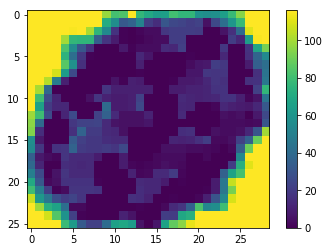

In [13]:
plt.imshow(bdata.sum(axis=2))
plt.colorbar()
plt.show()

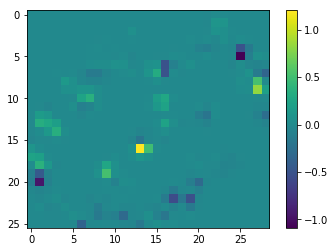

In [14]:
plt.imshow(cube[:,:,-1])
plt.colorbar()
plt.show()

### Getting Data

In [15]:
reverse = True
diagonal = False

In [16]:
if reverse:
    dataUF = cube.max() - cube + 1
    dataPH = cube.max() - cube + 1
else:
    dataUF = cube
    dataPH = cube - cube.min() + 1

### Generating Input File

In [17]:
if dataPH.dtype == np.float_:
    multiplier = 1e4
else:
    multiplier = 1

In [18]:
dataPH = (dataPH * multiplier).astype(int)

In [19]:
if reverse: 
    if diagonal:
        ainput = 'cube3dr.txt'
    else:
        ainput = 'cube3dr2.txt'
else:
    if diagonal:
        ainput = 'cube3d.txt'
    else:
        ainput = 'cube3d2.txt'

In [20]:
def write3dPath(f, data, i, j, k, ni, nj, nk):
    if ni < 0 or nj < 0 or nk < 0:
        return
    try:
        f.write('1 {} {} {} {} {} {} {}\n'.format(i, j, k, ni, nj, nk, max(data[i, j, k], data[ni, nj, nk])))
    except:
        pass

In [21]:
with open(ainput, 'w') as f:
    f.write(str(len(dataPH.shape))+'\n')
    for i in range(0, dataPH.shape[0]):
        for j in range(0, dataPH.shape[1]):
            for k in range(0, dataPH.shape[2]):
                f.write('0 {} {} {} {}\n'.format(i, j, k, dataPH[i, j, k]))
                write3dPath(f, dataPH, i, j, k, i+1, j, k)
                write3dPath(f, dataPH, i, j, k, i, j+1, k)
                write3dPath(f, dataPH, i, j, k, i, j, k+1)
                if diagonal:
                    write3dPath(f, dataPH, i, j, k, i, j+1, k+1)
                    write3dPath(f, dataPH, i, j, k, i, j+1, k-1)
                    write3dPath(f, dataPH, i, j, k, i+1, j, k+1)
                    write3dPath(f, dataPH, i, j, k, i+1, j, k-1)
                    write3dPath(f, dataPH, i, j, k, i+1, j+1, k)
                    write3dPath(f, dataPH, i, j, k, i+1, j-1, k)
                    write3dPath(f, dataPH, i, j, k, i+1, j+1, k+1)
                    write3dPath(f, dataPH, i, j, k, i+1, j-1, k+1)
                    write3dPath(f, dataPH, i, j, k, i-1, j+1, k+1)
                    write3dPath(f, dataPH, i, j, k, i-1, j-1, k+1)

### Running

In [22]:
import subprocess

In [23]:
subprocess.run(['./perseusMac', 'nmfsimtop', ainput, ainput[:-4]])

CompletedProcess(args=['./perseusMac', 'nmfsimtop', 'cube3dr2.txt', 'cube3dr2'], returncode=0)

### Reading Output File

In [24]:
if reverse: 
    if diagonal:
        aoutput = 'cube3dr_0.txt'
    else:
        aoutput = 'cube3dr2_0.txt'
else:
    if diagonal:
        aoutput = 'cube3d_0.txt'
    else:
        aoutput = 'cube3d2_0.txt'

In [25]:
pd2 = []
with open(aoutput) as f:
    for l in f.readlines():
        info = l.split()
        start = int(info[0]) / multiplier
        end = int(info[1]) / multiplier if int(info[1]) != -1 else -1
        pd2.append((start, end))
pd2 = sorted(pd2, key=lambda x:x[0])

In [27]:
persistencePH = []
for birth, death in pd2:
    if reverse:
        nbirth = cube.max() - death + 1 if death != -1 else cube.min() 
        ndeath = cube.max() - birth + 1
    else:
        nbirth = birth + cube.min() - 1
        ndeath = death + cube.min() - 1 if death != -1 else cube.max()
    persistencePH.append((nbirth, ndeath))

### Creating Pixel Objects

In [28]:
mat = []
for i in range(dataUF.shape[0]):
    aslice = []
    for j in range(dataUF.shape[1]):
        row = []
        for k in range(dataUF.shape[2]):
            element = dataUF[i][j][k]
            row.append(Pixel3D(i, j, k, element))
        aslice.append(row)
    mat.append(aslice)

In [29]:
arr = sorted([e for aslice in mat for row in aslice for e in row])

### Getting Neighbors for a Pixel

In [30]:
def append3DNeighbor(neighbors, x, y, z):
    if x < 0 or y < 0 or z < 0:
        return
    try:
        neighbors.append(mat[x][y][z])
    except:
        pass

In [31]:
def get_neighbors(pixel, diagonal=False):
    neighbors = []
    x = pixel.getX()
    y = pixel.getY()
    z = pixel.getZ()
    append3DNeighbor(neighbors, x-1, y, z)
    append3DNeighbor(neighbors, x+1, y, z)
    append3DNeighbor(neighbors, x, y-1, z)
    append3DNeighbor(neighbors, x, y+1, z)
    append3DNeighbor(neighbors, x, y, z-1)
    append3DNeighbor(neighbors, x, y, z+1)
    if diagonal:
        append3DNeighbor(neighbors, x-1, y-1, z-1)
        append3DNeighbor(neighbors, x-1, y-1, z)
        append3DNeighbor(neighbors, x-1, y-1, z+1)
        append3DNeighbor(neighbors, x-1, y, z-1)
        append3DNeighbor(neighbors, x-1, y, z+1)
        append3DNeighbor(neighbors, x-1, y+1, z-1)
        append3DNeighbor(neighbors, x-1, y+1, z)
        append3DNeighbor(neighbors, x-1, y+1, z+1)
        append3DNeighbor(neighbors, x, y+1, z+1)
        append3DNeighbor(neighbors, x, y-1, z+1)
        append3DNeighbor(neighbors, x, y+1, z-1)
        append3DNeighbor(neighbors, x, y-1, z-1)
        append3DNeighbor(neighbors, x+1, y-1, z-1)
        append3DNeighbor(neighbors, x+1, y-1, z)
        append3DNeighbor(neighbors, x+1, y-1, z+1)
        append3DNeighbor(neighbors, x+1, y, z-1)
        append3DNeighbor(neighbors, x+1, y, z+1)
        append3DNeighbor(neighbors, x+1, y+1, z-1)
        append3DNeighbor(neighbors, x+1, y+1, z)
        append3DNeighbor(neighbors, x+1, y+1, z+1)
    return neighbors

In [32]:
set([len(get_neighbors(pixel)) for pixel in arr])

{3, 4, 5, 6}

In [33]:
set([len(get_neighbors(pixel, True)) for pixel in arr])

{7, 11, 17, 26}

### Creating Topological Union-find

In [34]:
tuf = TopologicalUnionFind()
tuf

<UnionFind:
	elts=[],
	siz=[],
	par=[],
n_elts=0,n_comps=0>

In [35]:
for pixel in arr:
    tuf.add(pixel, pixel.getV())
    for neighbor in get_neighbors(pixel, diagonal):
        tuf.union(pixel, neighbor, pixel.getV())

In [36]:
pd = tuf.persistence()

In [37]:
persistenceUF = []
for birth, death in pd:
    if reverse:
        nbirth = cube.max() - death + 1 if np.isfinite(death) else cube.min() 
        ndeath = cube.max() - birth + 1
    else:
        nbirth = birth
        ndeath = death if np.isfinite(death) else cube.max()
    persistenceUF.append((nbirth, ndeath))

### Visualization

In [38]:
y = np.arange(0, len(persistenceUF))

In [39]:
xmin = [birth for birth, death in persistenceUF]
xmax = [death for birth, death in persistenceUF]

In [40]:
if reverse:
    xlim = (max(xmax), min(xmin))
else:
    xlim = (min(xmin), max(xmax))

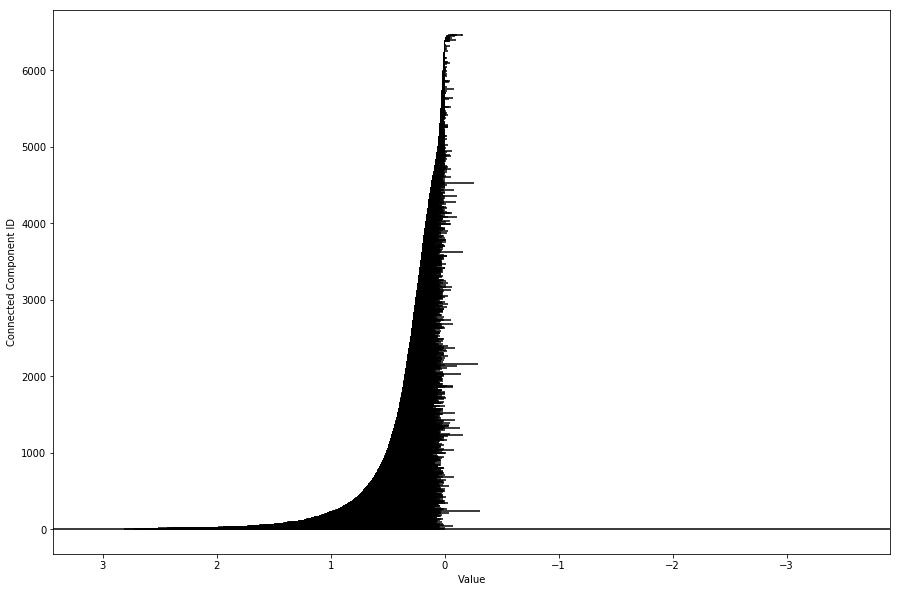

In [57]:
height = 2 + len(persistenceUF) // 10
height = 10 if height > 10 else height
plt.figure(figsize=(15,height))
plt.hlines(y=y, xmin=xmin, xmax=xmax)
plt.xlim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
# plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator((len(persistenceUF) // 10)))
plt.xlabel('Value')
plt.ylabel('Connected Component ID')
plt.show()

In [58]:
xmin = [birth for birth, death in persistenceUF]
xmax = [death for birth, death in persistenceUF]

In [59]:
if reverse:
    xlim = (max(xmax)+1, min(xmin)-1)
    xmin, xmax = xmax, xmin
else:
    xlim = (min(xmin)-1, max(xmax)+1)

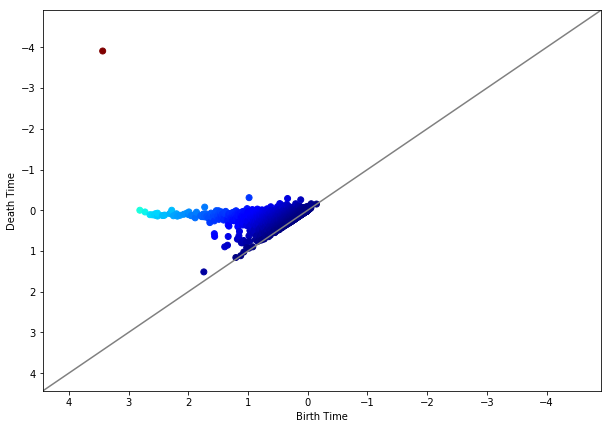

In [60]:
plt.figure(figsize=(10,7))
plt.scatter(xmin, xmax, c=np.array(xmax)-np.array(xmin), cmap='jet_r')
plt.xlim(xlim[0], xlim[1])
plt.ylim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Birth Time')
plt.ylabel('Death Time')
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], c='grey')
plt.show()

### Visualization2

In [61]:
y = np.arange(0, len(persistencePH))

In [62]:
xmin = [birth for birth, death in persistencePH]
xmax = [death for birth, death in persistencePH]

In [63]:
if reverse:
    xlim = (max(xmax), min(xmin))
else:
    xlim = (min(xmin), max(xmax))

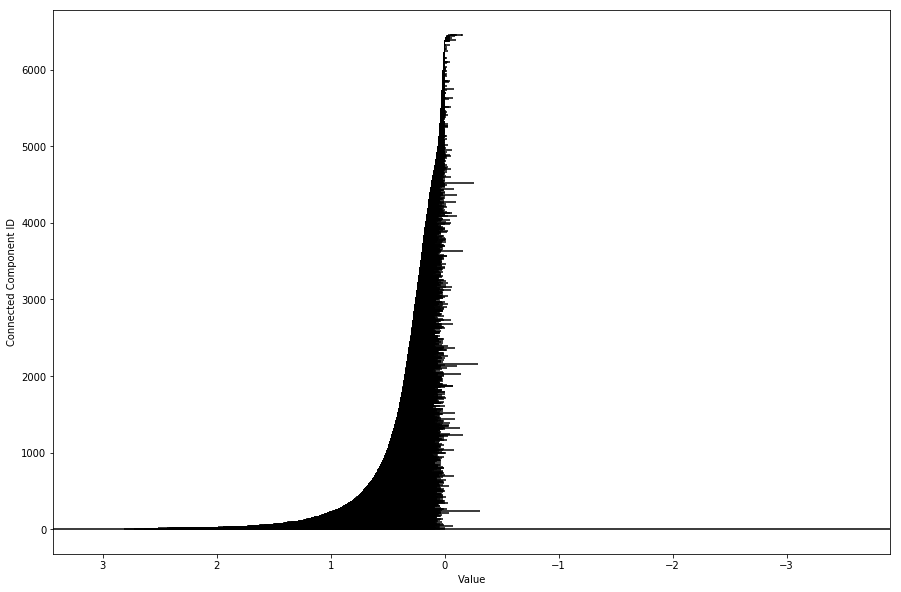

In [64]:
height = 2 + len(persistencePH) // 10
height = 10 if height > 10 else height
plt.figure(figsize=(15,height))
plt.hlines(y=y, xmin=xmin, xmax=xmax)
plt.xlim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
# plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Value')
plt.ylabel('Connected Component ID')
plt.show()

In [65]:
xmin = [birth for birth, death in persistencePH]
xmax = [death for birth, death in persistencePH]

In [66]:
if reverse:
    xlim = (max(xmax)+1, min(xmin)-1)
    xmin, xmax = xmax, xmin
else:
    xlim = (min(xmin)-1, max(xmax)+1)

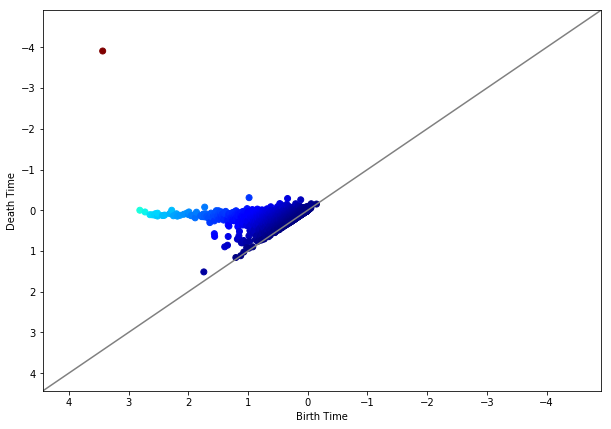

In [67]:
plt.figure(figsize=(10,7))
plt.scatter(xmin, xmax, c=np.array(xmax)-np.array(xmin), cmap='jet_r')
plt.xlim(xlim[0], xlim[1])
plt.ylim(xlim[0], xlim[1])
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.gca().yaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
plt.xlabel('Birth Time')
plt.ylabel('Death Time')
plt.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], c='grey')
plt.show()